In [1]:
!pip install ultralytics opencv-python paho-mqtt numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.6 MB/s eta 0:00:00


In [2]:
!pip install ultralytics opencv-python-headless

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving 1111.jpg to 1111.jpg
[INFO] Loading YOLOv8 model...
[INFO] Model classes loaded.
Human class IDs: [0]
Pet class IDs: [15, 16]
[INFO] Starting detection...

✅ Detection completed!
Total frames processed: 1
Total pet alerts: 0
Output video saved as: output_pets_vs_humans.avi

🎥 Showing a sample frame from output:


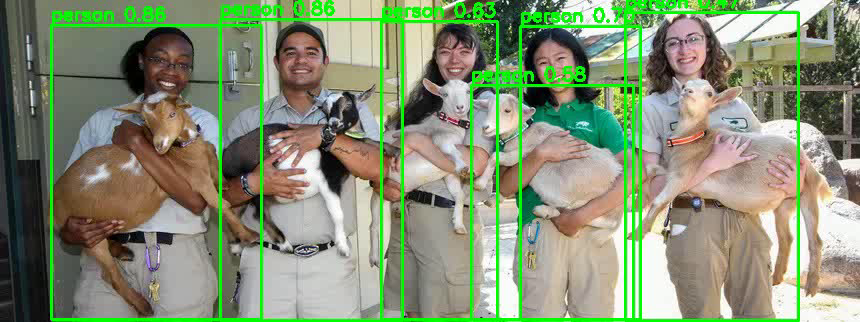


⬇️ Download your processed video below:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# ==========================
# 🧠 PETS vs HUMANS DETECTION SYSTEM
# Works in Google Colab using a pre-trained YOLOv8 model
# ==========================



import cv2
import torch
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow
import numpy as np
import os

# --------------------------
# 🔹 STEP 1: Upload your test video
# --------------------------
# print("📤 Upload a short video containing humans or pets (mp4 preferred)")
uploaded = files.upload()
# VIDEO_SOURCE = "https://cdn.pixabay.com/vimeo/381844993/dog-cat-57157.mp4?width=1280"

VIDEO_SOURCE = list(uploaded.keys())[0]  # automatically use uploaded file

# --------------------------
# 🔹 STEP 2: Load pretrained YOLOv8 model
# --------------------------
print("[INFO] Loading YOLOv8 model...")
model = YOLO("yolov8n.pt")  # or yolov8s.pt for better accuracy

# Get class names
class_names = model.names
print("[INFO] Model classes loaded.")

# Human and pet class IDs (COCO dataset)
HUMAN_CLASSES = [0]  # person
PET_CLASSES = [15, 16]  # cat, dog

print(f"Human class IDs: {HUMAN_CLASSES}")
print(f"Pet class IDs: {PET_CLASSES}")

# --------------------------
# 🔹 STEP 3: Open video and prepare output writer
# --------------------------
cap = cv2.VideoCapture(VIDEO_SOURCE)
if not cap.isOpened():
    raise RuntimeError("❌ Could not open video source")

fps = int(cap.get(cv2.CAP_PROP_FPS)) or 20
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = "output_pets_vs_humans.avi"
out = cv2.VideoWriter(output_path,
                      cv2.VideoWriter_fourcc(*"XVID"),
                      fps, (width, height))

# --------------------------
# 🔹 STEP 4: Detection loop
# --------------------------
frame_count = 0
pet_alert_count = 0

print("[INFO] Starting detection...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Run YOLO inference
    results = model(frame, verbose=False)
    detections = results[0].boxes.data.cpu().numpy()  # [x1, y1, x2, y2, conf, cls]

    pets_detected = False
    humans_detected = False

    for det in detections:
        x1, y1, x2, y2, conf, cls_id = det
        cls_id = int(cls_id)
        label = class_names.get(cls_id, "Unknown")

        if cls_id in HUMAN_CLASSES:
            color = (0, 255, 0)
            humans_detected = True
        elif cls_id in PET_CLASSES:
            color = (255, 0, 0)
            pets_detected = True
        else:
            continue

        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(frame, f"{label} {conf:.2f}", (int(x1), int(y1)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # If a pet is detected, trigger alert
    if pets_detected:
        pet_alert_count += 1
        print(f"⚠️ Alert! Pet detected at frame {frame_count}")

    out.write(frame)

# --------------------------
# 🔹 STEP 5: Cleanup and show summary
# --------------------------
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"\n✅ Detection completed!")
print(f"Total frames processed: {frame_count}")
print(f"Total pet alerts: {pet_alert_count}")
print(f"Output video saved as: {output_path}")

# --------------------------
# 🔹 STEP 6: Display and download result
# --------------------------
print("\n🎥 Showing a sample frame from output:")
cap_out = cv2.VideoCapture(output_path)
ret, frame_out = cap_out.read()
if ret:
    cv2_imshow(frame_out)
cap_out.release()

print("\n⬇️ Download your processed video below:")
files.download(output_path)
